<a href="https://colab.research.google.com/github/kiranvad/ComputationalTopology/blob/master/notebooks/colab/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
np.random.seed(0)

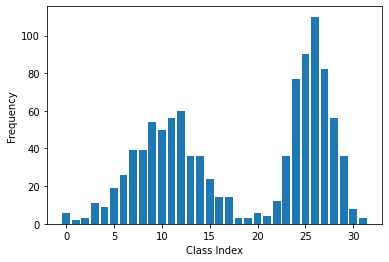

In [4]:
sampled_z = np.random.choice([0,1], size=1024)
data = ((sampled_z + 1) % 2) * np.random.normal(size=sampled_z.shape, loc=-1, scale=0.5) + \
    sampled_z * np.random.normal(size=sampled_z.shape, loc=1, scale=0.25)
nbins = 32
_, bins = np.histogram(data, bins=nbins)
class_data = np.apply_along_axis(lambda x: np.histogram(x, bins)[0], 1, data.reshape(-1, 1))
nclasses = nbins

plt.bar(np.arange(nclasses), height=np.sum(class_data, axis=0))
plt.xlabel('Class Index')
plt.ylabel('Frequency')
plt.show()

In [5]:
import jax.numpy as jnp
import jax.experimental.optimizers as optimizers
import jax
import functools

def random_vec(size):
    return np.random.normal(size=size, scale=1)

latent_dim = 1
hidden_dim = 16
input_dim = nclasses

def encoder(x, theta):
    '''The encoder takes as input x and gives out probability of z,
       expressed as normal distribution parameters. Assuming each z dim is independent,
       output |z| x 2 matrix'''
    w1, w2, w3, b1, b2, b3 = theta
    hx = jax.nn.relu(w1 @ x + b1)
    hx = jax.nn.relu(w2 @ hx + b2)
    out = w3 @ hx + b3
    # slice out stddeviation and make it positive
    reshaped = out.reshape((-1, 2))
    # we slice with ':' to keep rank same
    std = jax.nn.softplus(reshaped[:,1:])
    mu = reshaped[:,0:1]    
    return jnp.concatenate((mu, std), axis=1)
    
def init_theta(input_dim, hidden_units, latent_dim):
    '''Create inital theta parameters'''
    w1 = random_vec(size=(hidden_units, input_dim))
    b1 = np.zeros(hidden_units)
    w2 = random_vec(size=(hidden_units, hidden_units))
    b2 = np.zeros(hidden_units)
    # need to params per dim (mean, std)
    w3 = random_vec(size=(latent_dim * 2, hidden_units))
    b3 = np.zeros(latent_dim * 2)
    return [w1, w2, w3, b1, b2, b3]

# test them
theta = init_theta(input_dim, hidden_dim, latent_dim)
encoder(class_data[0], theta)

DeviceArray([[0.67200387, 0.00897247]], dtype=float32)

In [6]:
def decoder(z, phi):
    '''decoder takes as input the latant variable z and gives out probability of x.
    Decoder outputes a real number, then we use softmax activation to get probability across
    possible values of x. 
     '''
    w1, w2, w3, b1, b2, b3 = phi
    hz = jax.nn.relu(w1 @ z + b1)
    hz = jax.nn.relu(w2 @ hz + b2)
    out = jax.nn.softmax(w3 @ hz + b3)   
    return out

def init_phi(input_dim, hidden_units, latent_dim):
    '''Create inital phi parameters'''
    w1 = random_vec(size=(hidden_units, latent_dim))
    b1 = np.zeros(hidden_units)
    w2 = random_vec(size=(hidden_units, hidden_units))
    b2 = np.zeros(hidden_units)
    w3 = random_vec(size=(input_dim, hidden_units))
    b3 = np.zeros(input_dim)
    return [w1, w2, w3, b1, b2, b3]
# test it out
phi = init_phi(input_dim, hidden_dim, latent_dim)
decoder(np.array([1.2] * latent_dim), phi)

DeviceArray([1.4369683e-11, 2.8801292e-29, 3.2273541e-20, 7.1850895e-22,
             1.0793007e-22, 2.8247908e-20, 8.5903684e-09, 5.0419994e-28,
             3.8993281e-25, 1.9217204e-23, 1.3062071e-12, 2.6221546e-16,
             4.2119552e-23, 1.1967079e-20, 4.3358453e-27, 3.8699083e-20,
             1.3168897e-22, 3.3939088e-20, 5.1175348e-27, 3.9091000e-24,
             1.0000000e+00, 1.6622006e-19, 2.5878642e-29, 3.6575650e-17,
             5.0655268e-25, 3.9531148e-23, 5.9112239e-20, 3.3607102e-19,
             6.1983621e-12, 2.7988031e-19, 9.9489904e-13, 3.6622517e-27],            dtype=float32)

In [7]:
@jax.jit
def loss(x, theta, phi, rng_key):
    '''VAE Loss'''
    # reconstruction loss
    sampled_z_params = encoder(x, theta)
    # reparameterization trick
    # we use standard normal sample and multiply by parameters
    # to ensure derivatives correctly propogate to encoder
    sampled_z = jax.random.normal(rng_key, shape=(latent_dim,)) * sampled_z_params[:, 1] + sampled_z_params[:, 0]
    # log of prob
    rloss = -jnp.log(decoder(sampled_z, phi) @ x.T + 1e-8)
    # LK loss
    klloss = -0.5 - jnp.log(sampled_z_params[:, 1]) + 0.5 * sampled_z_params[:,0]**2 + 0.5 * sampled_z_params[:,1]**2    
    # combined    
    return jnp.array([rloss, jnp.mean(klloss)])
# test it out
loss(class_data[0], theta, phi, jax.random.PRNGKey(0))

batched_loss = jax.vmap(loss, in_axes=(0, None, None, None), out_axes=0)
batched_decoder = jax.vmap(decoder, in_axes=(0,None), out_axes=0)
batched_encoder = jax.vmap(encoder, in_axes=(0,None), out_axes=0)

# test batched loss
batched_loss(class_data[:4], theta, phi, jax.random.PRNGKey(0))

grad = jax.grad(lambda x, theta, phi, rng_key: jnp.mean(batched_loss(x, theta, phi, rng_key)), (1, 2))
fast_grad = jax.jit(grad)
fast_loss = jax.jit(batched_loss)

In [9]:
from tqdm.auto import tqdm

batch_size = 32
epochs = 16

key = jax.random.PRNGKey(0)
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-1)    
theta0 = init_theta(input_dim, hidden_dim, latent_dim)
phi0 = init_phi(input_dim, hidden_dim, latent_dim)
opt_state = opt_init((theta0, phi0))
losses = []
for e in tqdm(range(epochs)):
    for bi,i in enumerate(range(0, len(data), batch_size)):
        # make a batch into shape B x 1
        batch = class_data[i:(i + batch_size)]
        # udpate random number key
        key, subkey = jax.random.split(key)
        # get current parameter values from optimizer
        theta, phi = get_params(opt_state)
        last_state = opt_state
        # compute gradient and update
        grad = fast_grad(batch, theta, phi, key)    
        opt_state = opt_update(bi, grad, opt_state)
        lvalue = jnp.mean(fast_loss(batch, theta, phi, subkey), axis=0)
        losses.append(lvalue)

  0%|          | 0/16 [00:00<?, ?it/s]

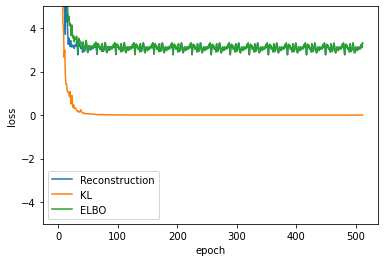

In [10]:
plt.plot([l[0] for l in losses], label='Reconstruction')
plt.plot([l[1] for l in losses], label='KL')
plt.plot([l[1] + l[0] for l in losses], label='ELBO')
plt.legend()
plt.ylim(-5, 5)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

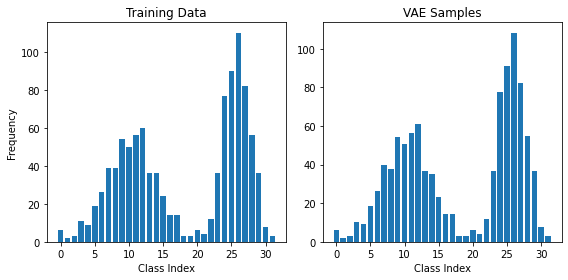

In [11]:
zs = np.random.normal(size=(1024, 1))
sampled_x = batched_decoder(zs, phi)
fig, axs = plt.subplots(ncols=2, figsize=(8,4))
axs[0].set_title('Training Data')
axs[0].bar(np.arange(nbins), height=np.sum(class_data, axis=0))
axs[0].set_xlabel('Class Index')
axs[0].set_ylabel('Frequency')
axs[1].set_title('VAE Samples')
axs[1].bar(np.arange(nbins), height=np.sum(sampled_x, axis=0))
axs[1].set_xlabel('Class Index')
plt.tight_layout()
plt.show()